In [92]:
import selfies as sf
import pathlib as Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re

In [164]:
of_dataset = pd.read_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\df_mofs_v1.csv")

In [165]:
of_dataset.columns

Index(['MOFid', 'metal', 'linker', 'logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000', 'LCD', 'PLD', 'LFPD', 'cm3_g',
       'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF',
       'AV_cm3_g', 'NAV_cm3_g', 'All_Metals', 'Has_OMS', 'Open_Metal_Sites'],
      dtype='object')

In [135]:
geometry_info = mof_dataset[['LCD', 'PLD', 'LFPD', 'cm3_g',
       'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF',
       'AV_cm3_g', 'NAV_cm3_g']]

precursors_info = mof_dataset[['MOFid', 'metal', 'linker', 'Has_OMS', 'Open_Metal_Sites']]

target_info = mof_dataset[['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 'pure_uptake_methane_298.00_6500000']]

In [136]:

# Standardize geometry features
geometry_scaler = StandardScaler()
geometry_info_norm = pd.DataFrame(
    geometry_scaler.fit_transform(geometry_info),
    columns=geometry_info.columns,
    index=geometry_info.index
)

# Standardize targets
target_scaler = StandardScaler()
target_info_norm = pd.DataFrame(
    target_scaler.fit_transform(target_info),
    columns=target_info.columns,
    index=target_info.index
)

# Save scalers
import joblib
joblib.dump(geometry_scaler, 'geometry_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

['target_scaler.pkl']

In [137]:
print(geometry_info_norm.min())
print(geometry_info_norm.max())

LCD           -0.930531
PLD           -1.071692
LFPD          -1.083744
cm3_g         -2.542419
ASA_m2_cm3    -1.413214
ASA_m2_g      -1.001030
NASA_m2_cm3   -0.472329
NASA_m2_g     -0.431001
AV_VF         -2.643680
AV_cm3_g      -0.961112
NAV_cm3_g     -0.025221
dtype: float64
LCD            13.329026
PLD             9.864606
LFPD           13.678638
cm3_g           6.537135
ASA_m2_cm3      2.608635
ASA_m2_g        5.548906
NASA_m2_cm3     5.653545
NASA_m2_g       9.040795
AV_VF           3.609937
AV_cm3_g       29.896164
NAV_cm3_g      57.070888
dtype: float64


In [138]:
print(target_info_norm.min())
print(target_info_norm.max())

logKH_CO2                            -5.013828
pure_uptake_CO2_298.00_15000         -1.299537
pure_uptake_methane_298.00_6500000   -1.258191
dtype: float64
logKH_CO2                              2.949122
pure_uptake_CO2_298.00_15000           4.699299
pure_uptake_methane_298.00_6500000    11.045829
dtype: float64


In [139]:
count = 0
for i in precursors_info['metal']:
    if len(i) > 12:
        print(i)
        count += 1

print(count)

[Na][Y][W][Cs]
[W][Na][K][Rb][Y]
[Co][K][W][Cu]
[Co][K][W][Cr]
[Na][Mo][Al][Eu]
5


In [140]:
geometry_info_norm.to_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_CORE_geometry.csv", index=False)
target_info_norm.to_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_CORE_target.csv", index=False)

In [141]:
def parse_metal_string(metal_str):

    metals = re.findall(r'\[([^\]]+)\]', metal_str)
    
    return metals

def build_metal_vocabulary(df, metal_column='metal'):

    all_metals = set()
    max_metals = 0
    
    for metal_str in df[metal_column]:
        metals = parse_metal_string(str(metal_str))
        all_metals.update(metals)
        max_metals = max(max_metals, len(metals))
    
    # Create vocabulary with padding token
    unique_metals = sorted(all_metals)
    metal_to_idx = {metal: i for i, metal in enumerate(unique_metals)}
    metal_to_idx['[nop]'] = len(metal_to_idx)
    
    print(f"Found {len(unique_metals)} unique metals")
    print(f"Vocabulary size: {len(metal_to_idx)} (including padding)")
    print(f"Maximum metals per MOF: {max_metals}")
    
    return metal_to_idx, max_metals

def encode_metals(df, metal_to_idx, max_length, metal_column='metal', oms_column='Open_Metal_Sites'):
    """
    Convert metal strings to integer sequences with OMS flags.
    
    Args:
        df: DataFrame with metal and OMS columns
        metal_to_idx: Metal vocabulary dictionary
        max_length: Sequence length (pad/truncate to this)
        metal_column: Name of metal column
        oms_column: Name of Open Metal Sites column
    
    Returns:
        metal_ids: Array of shape (n_mofs, max_length)
        metal_oms_flags: Array of shape (n_mofs, max_length)
    """
    n_mofs = len(df)
    metal_ids = np.zeros((n_mofs, max_length), dtype=np.int32)
    metal_oms_flags = np.zeros((n_mofs, max_length), dtype=np.float32)
    
    for i, row in df.iterrows():
        # Parse metals
        metals = parse_metal_string(str(row[metal_column]))
        
        # Convert to IDs (truncate if too long)
        for j, metal in enumerate(metals[:max_length]):
            metal_ids[i, j] = metal_to_idx.get(metal, 0)
        
        # Parse OMS
        oms_str = str(row[oms_column])
        if oms_str and oms_str != 'nan' and oms_str.strip():
            oms_metals = [m.strip() for m in oms_str.replace('[', '').replace(']', '').split(',')]
            
            # Set OMS flags
            for j, metal in enumerate(metals[:max_length]):
                if metal in oms_metals:
                    metal_oms_flags[i, j] = 1.0
    
    return metal_ids, metal_oms_flags



In [142]:
def encode_linker(df, linker_column='linker'):
    linkers = df[linker_column].tolist()

    # Build vocabulary
    linker_vocab = sf.get_alphabet_from_selfies(linkers)
    linker_vocab.add('[nop]')  # Padding token
    linker_vocab = list(sorted(linker_vocab))

    # Determine padding length
    pad_to_len = max(sf.len_selfies(s) for s in linkers)
    
    # Create symbol to index mapping
    symbol_to_idx = {s: i for i, s in enumerate(linker_vocab)}

    print(f"Linker vocabulary size: {len(linker_vocab)}")
    print(f"Padding length: {pad_to_len}")
    
    # Encode each linker
    linker_ids = []
    for linker in linkers:
        # enc_type="label" returns only label (not tuple)
        label = sf.selfies_to_encoding(
            selfies=linker,
            vocab_stoi=symbol_to_idx,
            pad_to_len=pad_to_len,
            enc_type="label"
        )
        linker_ids.append(label)
    
    linker_ids = np.array(linker_ids)

    return linker_ids, symbol_to_idx

In [143]:
# Usage:
# Step 1: Build vocabulary
metal_vocab, max_metals = build_metal_vocabulary(precursors_info, metal_column='metal')

# Step 2: Encode all metals
metal_ids, metal_oms_flags = encode_metals(
    precursors_info, 
    metal_vocab, 
    max_length=max_metals,  # Or set fixed length like 5
    metal_column='metal',
    oms_column='Open_Metal_Sites'
)

Found 54 unique metals
Vocabulary size: 55 (including padding)
Maximum metals per MOF: 5


In [144]:
linker_ids, linker_vocab = encode_linker(precursors_info, linker_column='linker')

Linker vocabulary size: 86
Padding length: 198


In [145]:
precursors_info_encoded = precursors_info.copy()  # To avoid SettingWithCopyWarning
precursors_info_encoded['linker'] = linker_ids.tolist()
precursors_info_encoded['metal'] = metal_ids.tolist()

In [147]:
precursors_info_encoded['linker']
precursors_info_encoded['metal']

0       [28, 0, 0, 0, 0]
1        [9, 0, 0, 0, 0]
2       [12, 0, 0, 0, 0]
3       [24, 0, 0, 0, 0]
4        [8, 0, 0, 0, 0]
              ...       
3328     [7, 0, 0, 0, 0]
3329    [33, 7, 0, 0, 0]
3330    [33, 7, 0, 0, 0]
3331    [53, 0, 0, 0, 0]
3332    [48, 0, 0, 0, 0]
Name: metal, Length: 3333, dtype: object

In [148]:
print(metal_vocab)
joblib.dump(metal_vocab, 'metal_vocabulary.pkl')

{'Ag': 0, 'Al': 1, 'Au': 2, 'Ba': 3, 'Be': 4, 'Bi': 5, 'Ca': 6, 'Cd': 7, 'Ce': 8, 'Co': 9, 'Cr': 10, 'Cs': 11, 'Cu': 12, 'Dy': 13, 'Er': 14, 'Eu': 15, 'Fe': 16, 'Ga': 17, 'Gd': 18, 'Hf': 19, 'Ho': 20, 'In': 21, 'Ir': 22, 'K': 23, 'La': 24, 'Li': 25, 'Lu': 26, 'Mg': 27, 'Mn': 28, 'Mo': 29, 'Na': 30, 'Nb': 31, 'Nd': 32, 'Ni': 33, 'Pb': 34, 'Pd': 35, 'Pr': 36, 'Pt': 37, 'Rb': 38, 'Re': 39, 'Rh': 40, 'Ru': 41, 'Sm': 42, 'Sn': 43, 'Sr': 44, 'Tb': 45, 'Th': 46, 'Tm': 47, 'U': 48, 'V': 49, 'W': 50, 'Y': 51, 'Yb': 52, 'Zn': 53, '[nop]': 54}


['metal_vocabulary.pkl']

In [149]:
print(linker_vocab)
joblib.dump(linker_vocab, 'linker_vocabulary.pkl')

{'[#Branch1]': 0, '[#Branch2]': 1, '[#CH0]': 2, '[#C]': 3, '[#N]': 4, '[/-Ring1]': 5, '[/-Ring2]': 6, '[/Br]': 7, '[/C@@H1]': 8, '[/C@@]': 9, '[/C@H1]': 10, '[/C@]': 11, '[/CH0]': 12, '[/CH1]': 13, '[/C]': 14, '[/NH0]': 15, '[/NH1]': 16, '[/N]': 17, '[/S]': 18, '[=Branch1]': 19, '[=Branch2]': 20, '[=CH0]': 21, '[=CH1]': 22, '[=C]': 23, '[=N+1]': 24, '[=NH0]': 25, '[=N]': 26, '[=O]': 27, '[=P@]': 28, '[=P]': 29, '[=Ring1]': 30, '[=Ring2]': 31, '[=S]': 32, '[As]': 33, '[B]': 34, '[Br]': 35, '[Branch1]': 36, '[Branch2]': 37, '[C@@H1]': 38, '[C@@]': 39, '[C@H1]': 40, '[C@]': 41, '[CH0]': 42, '[CH1]': 43, '[CH2]': 44, '[CH3]': 45, '[C]': 46, '[Cl]': 47, '[F]': 48, '[Ge@@]': 49, '[Ge@]': 50, '[Ge]': 51, '[I]': 52, '[N+1]': 53, '[NH0]': 54, '[NH1]': 55, '[N]': 56, '[O-1]': 57, '[OH0]': 58, '[OH1]': 59, '[O]': 60, '[P@@]': 61, '[P@H1]': 62, '[P@]': 63, '[PH0]': 64, '[P]': 65, '[Ring1]': 66, '[Ring2]': 67, '[S@@]': 68, '[S@]': 69, '[SH0]': 70, '[S]': 71, '[Sb]': 72, '[Se]': 73, '[Si]': 74, '[\\

['linker_vocabulary.pkl']

In [150]:
precursors_info_encoded

,MOFid,metal,linker,Has_OMS,Open_Metal_Sites
0,ABAYIO_clean,"[28, 0, 0, 0, 0]","[46, 36, 19, 46, 19, 46, 27, 58, 23, 46, 36, 1...",No,
1,ABAYOU_clean,"[9, 0, 0, 0, 0]","[46, 19, 46, 27, 37, 66, 0, 46, 23, 46, 36, 19...",No,
2,ABETIN_clean,"[12, 0, 0, 0, 0]","[46, 23, 46, 19, 19, 23, 46, 26, 66, 19, 46, 2...",No,
3,ABEXEM_clean,"[24, 0, 0, 0, 0]","[60, 23, 36, 46, 58, 46, 26, 46, 26, 46, 19, 6...",Yes,La
4,ABEXIQ_clean,"[8, 0, 0, 0, 0]","[58, 46, 19, 46, 27, 46, 26, 46, 26, 46, 19, 6...",Yes,Ce
...,...,...,...,...,...
3328,ZURLAB_clean,"[7, 0, 0, 0, 0]","[46, 20, 66, 1, 26, 46, 19, 1, 26, 42, 66, 36,...",No,
3329,ZURQOS_clean,"[33, 7, 0, 0, 0]","[46, 36, 26, 46, 23, 46, 23, 36, 66, 46, 55, 4...",Yes,Ni
3330,ZURROT_clean,"[33, 7, 0, 0, 0]","[46, 36, 26, 46, 23, 46, 23, 36, 66, 46, 56, 4...",Yes,"Cd,Ni"
3331,ZUSBOG_clean,"[53, 0, 0, 0, 0]","[46, 19, 46, 27, 37, 66, 37, 46, 23, 46, 23, 3...",Yes,Zn


In [151]:
def create_oms_flags(df):

    oms_flags_list = []
    
    for idx, row in df.iterrows():
        if row['Has_OMS'] == 'No':
            oms_flags = [0.0] * 5
        
        else:
            oms_ids = set()
            for m in row['Open_Metal_Sites'].split(','):
                try:
                    oms_ids.add(metal_vocab[m.strip()])
                except:
                    pass  # 없는 metal 무시
            
            # 각 metal ID 확인
            oms_flags = [1.0 if mid in oms_ids else 0.0 for mid in row['metal']]
        
        oms_flags_list.append(oms_flags)
    
    return oms_flags_list

In [152]:
oms_flags = create_oms_flags(precursors_info_encoded)

In [153]:
precursors_info_encoded['OMS_flag'] = list(oms_flags)

In [154]:
precursors_info_encoded = precursors_info_encoded[['MOFid', 'metal', 'linker', 'OMS_flag']]

In [155]:
precursors_info_encoded

,MOFid,metal,linker,OMS_flag
0,ABAYIO_clean,"[28, 0, 0, 0, 0]","[46, 36, 19, 46, 19, 46, 27, 58, 23, 46, 36, 1...","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,ABAYOU_clean,"[9, 0, 0, 0, 0]","[46, 19, 46, 27, 37, 66, 0, 46, 23, 46, 36, 19...","[0.0, 0.0, 0.0, 0.0, 0.0]"
2,ABETIN_clean,"[12, 0, 0, 0, 0]","[46, 23, 46, 19, 19, 23, 46, 26, 66, 19, 46, 2...","[0.0, 0.0, 0.0, 0.0, 0.0]"
3,ABEXEM_clean,"[24, 0, 0, 0, 0]","[60, 23, 36, 46, 58, 46, 26, 46, 26, 46, 19, 6...","[1.0, 0.0, 0.0, 0.0, 0.0]"
4,ABEXIQ_clean,"[8, 0, 0, 0, 0]","[58, 46, 19, 46, 27, 46, 26, 46, 26, 46, 19, 6...","[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
3328,ZURLAB_clean,"[7, 0, 0, 0, 0]","[46, 20, 66, 1, 26, 46, 19, 1, 26, 42, 66, 36,...","[0.0, 0.0, 0.0, 0.0, 0.0]"
3329,ZURQOS_clean,"[33, 7, 0, 0, 0]","[46, 36, 26, 46, 23, 46, 23, 36, 66, 46, 55, 4...","[1.0, 0.0, 0.0, 0.0, 0.0]"
3330,ZURROT_clean,"[33, 7, 0, 0, 0]","[46, 36, 26, 46, 23, 46, 23, 36, 66, 46, 56, 4...","[1.0, 1.0, 0.0, 0.0, 0.0]"
3331,ZUSBOG_clean,"[53, 0, 0, 0, 0]","[46, 19, 46, 27, 37, 66, 37, 46, 23, 46, 23, 3...","[1.0, 0.0, 0.0, 0.0, 0.0]"


In [156]:
precursors_info_encoded.to_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_CORE_precursor.csv", index=False)

In [119]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


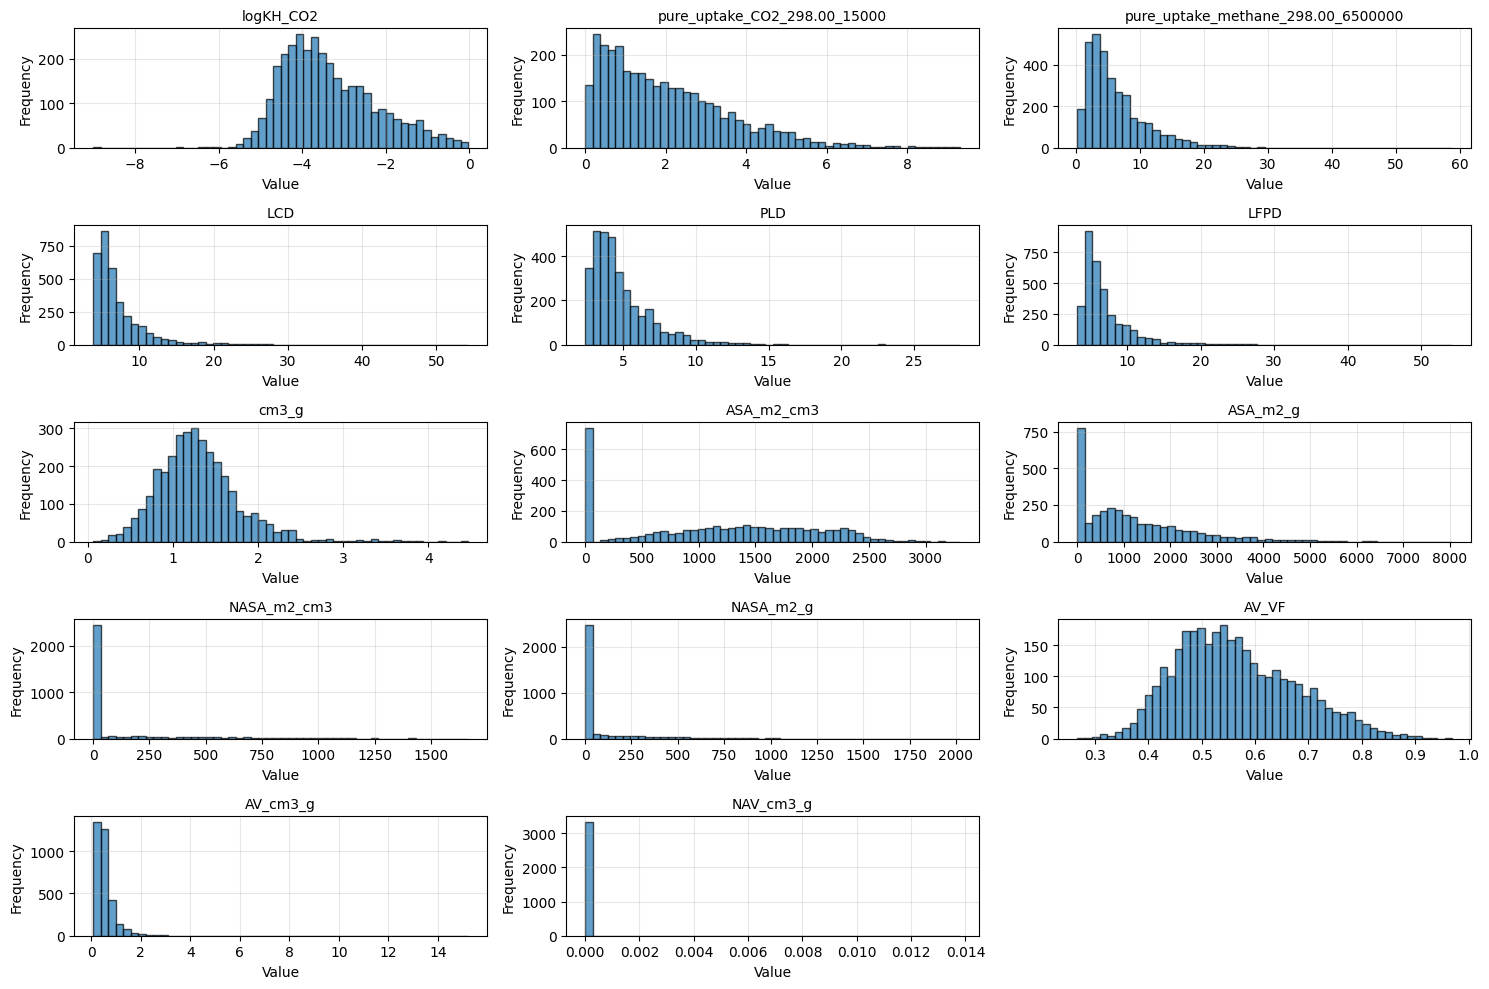

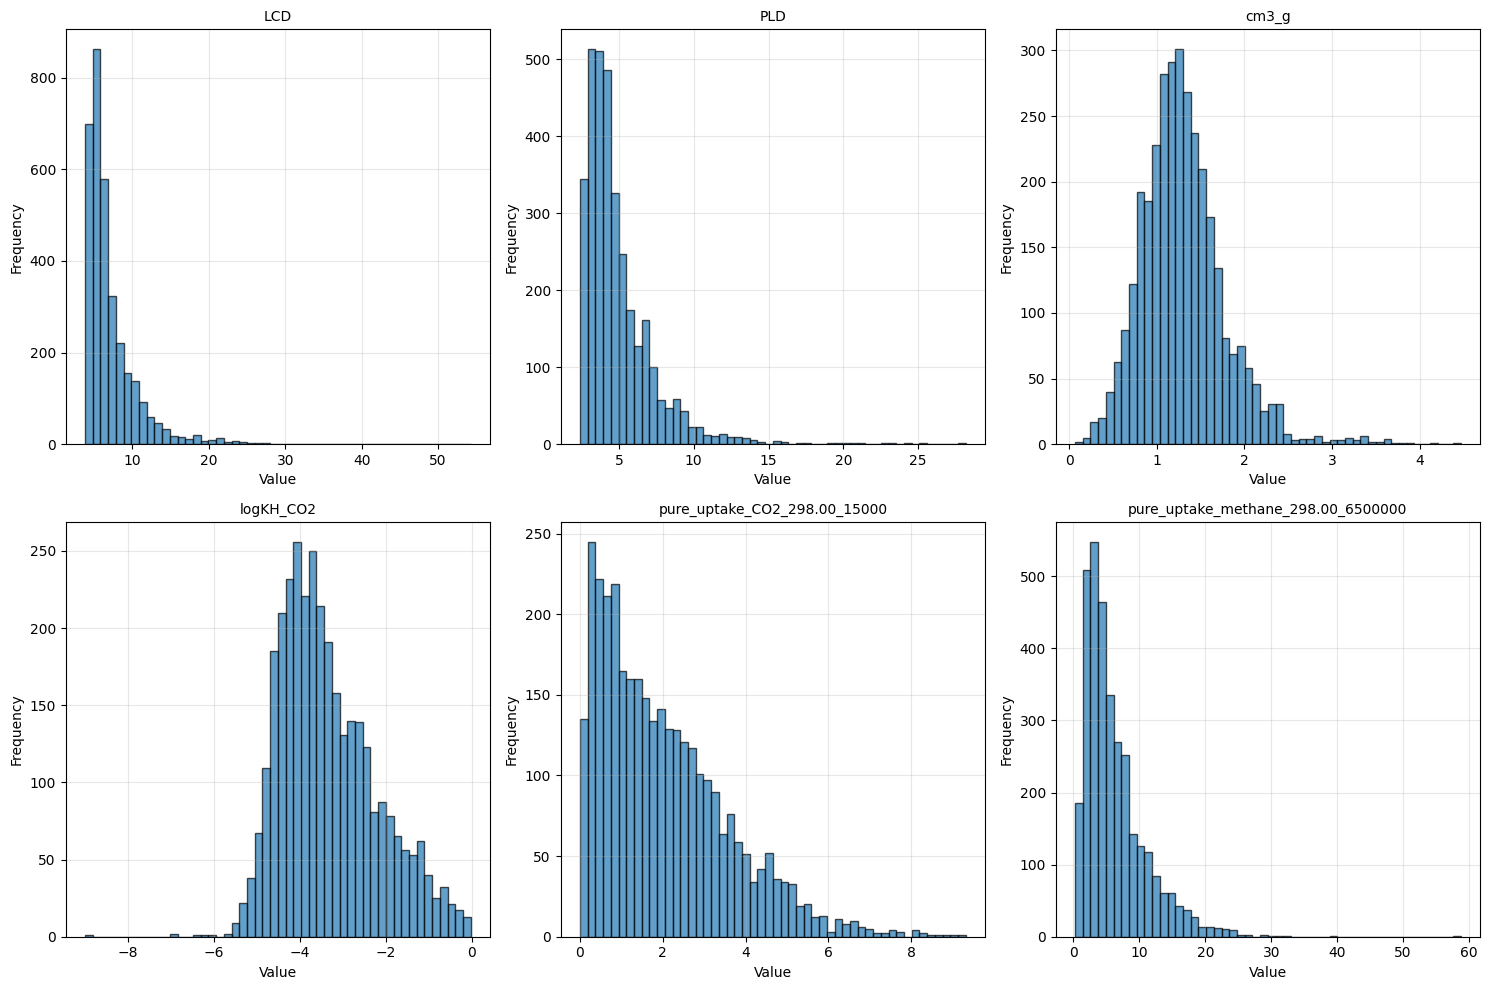

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df, columns=None, figsize=(15, 10)):
    """
    데이터셋의 특성 분포 시각화
    
    Args:
        df: DataFrame
        columns: 시각화할 컬럼 리스트 (None이면 모든 숫자형 컬럼)
        figsize: Figure 크기
    """
    # 숫자형 컬럼만 선택
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3  # 3열 그리드
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        # Histogram + KDE
        axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(alpha=0.3)
    
    # 빈 subplot 제거
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


# 사용 예시:
# 1. 모든 숫자형 특성 분포
plot_feature_distributions(mof_dataset)

# 2. 특정 특성들만 보기
feature_cols = ['LCD', 'PLD', 'cm3_g', 'logKH_CO2', 
                'pure_uptake_CO2_298.00_15000', 'pure_uptake_methane_298.00_6500000']
plot_feature_distributions(mof_dataset, columns=feature_cols)

In [158]:
MOF_final_numeric_dataset = pd.concat([geometry_info_norm, precursors_info_encoded, target_info_norm], axis=1)


In [159]:
MOF_final_numeric_dataset = parse_list_columns(MOF_final_numeric_dataset)

In [160]:
MOF_final_numeric_dataset.to_csv('merged_mof_dataset.csv', index=False)